In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct
import matplotlib.pyplot as plt
import seaborn as sns
from pyDOE import *
from scipy.stats.distributions import norm
from datetime import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline


In [2]:
train_set_features = pd.read_csv("nasa-data/training_set_features.csv")
unique_storms = np.unique(train_set_features["Storm ID"])
print(len(unique_storms))
unique_storms[0]

494


'abs'

In [3]:
train_set_labels = pd.read_csv("nasa-data/training_set_labels.csv")
train_set_labels.head()

,Image ID,Wind Speed
0,nhe_000,34
1,nhe_001,34
2,nhe_002,34
3,nhe_003,33
4,nhe_004,32


In [4]:
int_df = pd.merge(train_set_features, train_set_labels, how ='inner', on =['Image ID', 'Image ID'])
int_df.head()

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed
0,nhe_000,nhe,0,2,34
1,nhe_001,nhe,1800,2,34
2,nhe_002,nhe,3600,2,34
3,nhe_003,nhe,5402,2,33
4,nhe_004,nhe,9001,2,32


In [5]:
for i in range(494):  
    nhe = int_df[int_df["Storm ID"]== unique_storms[i]]
    nhe.plot(x="Relative Time", y="Wind Speed")
    titlestr = "Strom ID:"+unique_storms[i]
    plt.title(titlestr, size = 14)
    plt.ylabel("Wind Speed")
    plt.savefig("image-storm/"+unique_storms[i]+".png")
    plt.close()

In [6]:
# Number of samples. 
n = 70257
# Generate "time" variable. 
t = np.arange(n)
data_df = pd.DataFrame({'t' : t})

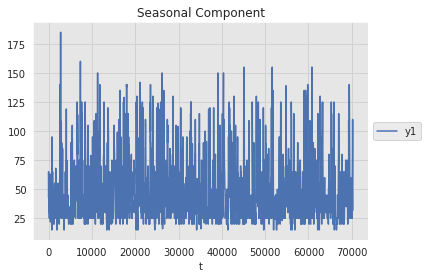

In [7]:
# Generate seasonal variables. 
def seasonal(int_df, unique_storms):
    """Generate a sinusoidal curve."""
    actual_speed = []
    for i in range(494):  
        actual_speed.append(int_df[int_df["Storm ID"]== unique_storms[i]]["Wind Speed"])
    y1 = [item for sublist in actual_speed for item in sublist]
    return y1
# Define target variable. 
data_df['y1'] = seasonal(int_df, unique_storms)
#Let us plot this seasonal variable:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Seasonal Component', xlabel='t', ylabel='');

In [8]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

kernel_1  = k0 + k1 

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [10]:
print(data_df['y1'])

0        43
1        44
2        45
3        52
4        53
         ..
70252    42
70253    40
70254    37
70255    35
70256    32
Name: y1, Length: 70257, dtype: int64


In [11]:
X = data_df['t'].values.reshape(n, 1)
y = data_df['y1'].values.reshape(n, 1)
prop_train = 0.7
n_train = round(prop_train * n)
n_train =2500
X_train = X[:n_train]
y_train = y[:n_train]

#X_test = X[n_train:]
#y_test = y[n_train:]
X_test = X[n_train:n_train+100]
y_test = y[n_train:n_train+100]

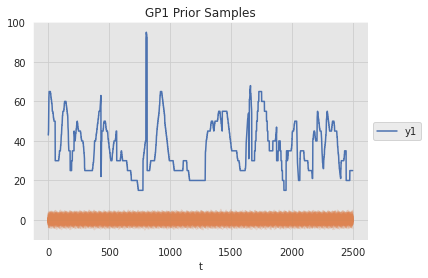

In [12]:
gp1_prior_samples = gp1.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp1_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP1 Prior Samples', xlabel='t');

In [13]:
gp1.fit(X_train, y_train)
GaussianProcessRegressor(alpha=0.01,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                         n_restarts_optimizer=10, normalize_y=True)
# Generate predictions.
y_pred, y_std = gp1.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

/home/vermeer/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified upper bound 0.25. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


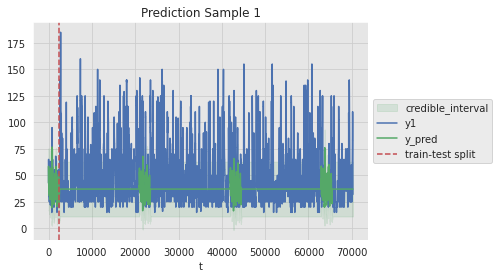

In [14]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='');

R2 Score Train =  0.929
R2 Score Test = -0.346
MAE Train =  2.777
MAE Test =  15.180


/home/vermeer/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


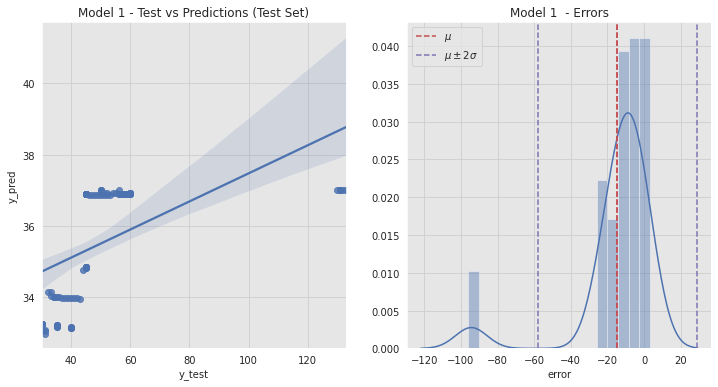

In [15]:
from sklearn.metrics import mean_absolute_error
print(f'R2 Score Train = {gp1.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp1.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp1.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp1.predict(X_test)): 0.3f}')

#Errors
errors = gp1.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp1.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 1 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 1  - Errors', xlabel='error', ylabel=None);